In [ ]:
---
title: "Introduction to Quantum Singular Value Transformation"
description: "Or grand unification of quantum algorithms, if you feel a bit grandiose."
aliases:
  - quantum_singular_value_transformation_intro.html
bibliography: references.bib
csl: physical-review-letters.csl
toc: true
image: what_to_use_qc_for.svg
date: '2023-05-15'

format:
  html:
    html-math-method: mathjax
    include-in-header:
      - text: |
          <script>
          window.MathJax = {
            tex: {
              tags: 'ams'
            }
          };
          </script>
---

In [52]:
import numpy as np
import scipy.stats
import scipy.linalg

import matplotlib.pyplot as plt

from functools import reduce

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

import contextlib
import io

def quiet(func):
    def quiet_func(*args, **kwargs):    
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            res = func(*args, **kwargs)
        return res
    return quiet_func

# Quantum signal processing

Define the basic setup of quantum signal processing.
- Implementing arbitrary polynomials subject to conditions.
- Measure in $|\pm\rangle$ basis.
- Automated way to find phases.

In [2]:
def R(a):
    """Singla operator in R-convention"""
    
    b = np.sqrt(1-a**2)
    W = np.array([
        [a, b],
        [b, -a]])

    return W

def Sz(phi):
    return np.diag([np.exp(1j*phi), np.exp(-1j*phi)])

def angles_from_Wx_to_R(phis):
    assert len(phis)>0, 'At least one angle must be provided.'
    phis = \
    [phis[0]+(2*len(phis)-3)*np.pi/4] \
    + [phi-np.pi/2 for phi in phis[1:-1]] \
    + [phis[-1]-np.pi/4]
    
    return phis 

def apply_QSP(w, phis):
    """Computes S(phi_0) @ w @ s(phi_1) @ w ... @ S(phi_d-1) @ w @ S(phi_d)."""
    
    phis = angles_from_Wx_to_R(phis)
    
    res = Sz(phis[-1])
    for phi in phis[:-1][::-1]:        
        res = Sz(phi) @ w @ res
    
    return res

Exercise: implement polynomial by phases.

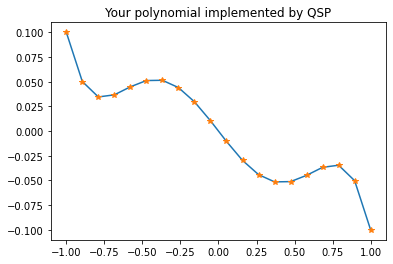

In [3]:
# An excersize.

def polynomial_value(coeffs, x):
    """ Computes c[0]*x**0 + c[1]*x**1+...+c[n]*x**n. """
    x = np.array([x])
    return (np.array(coeffs) * x**np.arange(len(coeffs))).sum()

# Som arbitrary set of polynomial coefficiets.
# Must define even or odd polynomial p(x) that satisfies p(x)<1 for -1<x<1. 

coeffs =  [0., -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 20)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

# Compute matrix elements of the QSP sequence
unitaries = [apply_QSP(R(xi), phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

# QSVT

- Block embedding in the computational basis
$$U=\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}$$
- For a single-qubit embedding $U=|0\rangle \langle0|\otimes A+\dots$.
- More generally, there is some basis change $B_L, B_R$ that leads to the standard block-encoding
$$U=B_L\begin{pmatrix}A&\cdot\\\cdot&\cdot\end{pmatrix}B_R$$
With any such basis we associated projectors $\Pi_L=B_L\left(|0\rangle\langle0|\otimes \mathbb{1} \right)B_L^\dagger $ which satisfy
$$\Pi_L U \Pi_R = B_L\begin{pmatrix}A&0\\0&0\end{pmatrix}B_R$$
- We need access to 
$$\Pi_L(\phi)=e^{(2\Pi_L-\mathbb{I})\phi}=B_L \begin{pmatrix}e^{i\phi}&0\\ 0&e^{-i\phi}\end{pmatrix}B_L^\dagger$$

Then, the main statement of QSVT is the following. A bit awkwardly, it needs to be split in two cases. First consider when the polynomial is even (the number of phases is odd)

$$U_{\phi}=\prod_{i=0}^{d/2-1}\Pi_R(\phi_{2i})U^\dagger\Pi_L(\phi_{2i+1})U$$
When the polynomial is odd (the number of phases even)

$$U_{\phi}=\Pi_L(\phi_{0})U\prod_{i=1}^{(d-1)/2}\Pi_R(\phi_{2i-1})U^\dagger\Pi_L(\phi_{2i})U$$

In [38]:
def projector_rotation(P, phi):
    n = len(P)
    return np.eye(n)*np.cos(phi)-1j*(2*P-np.eye(n))*np.sin(phi)


def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res

# Amplitude amplification

Encompasses
1. Grover's search.
1. Oblivious amplitude amplification.
1. Used in other quantum algorithms.

## Test

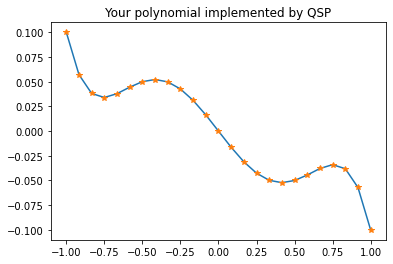

In [39]:
P = np.diag([1, 0])


coeffs =  [0, -0.2, 0., 0.5, 0., -0.4]
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
phis = angles_from_Wx_to_R(phis)

# Compute polynomial values in the range [-1, 1] directly
x = np.linspace(-1, 1, 25)
poly_values = [polynomial_value(coeffs, xi) for xi in x]

unitaries =[apply_QSVT(R(xi), P, P, phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Verify they agree.
# assert np.allclose(poly_values, matrix_elements, atol=1e-5)
plt.plot(x, poly_values);
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

## Poly test

In [40]:
target_function = pyqsp.poly.PolySign()

coeffs_list = []
vals = []
for N in range(1, 100)[::1]:
    degree = np.ceil(np.sqrt(N))
    if degree % 2 == 0:
        degree += 1
        
    coeffs, scale = quiet(target_function.generate)(
        degree, 
        delta=2*np.sqrt(N), 
        ensure_bounded=True, 
        return_scale=True);
    
    coeffs_list.append(coeffs)
    vals.append(polynomial_value(coeffs, 1/np.sqrt(N)))

## Implementation

In [43]:
np.random.seed(42)


def projector_from_state(state):
    return np.outer(state, state.conj())


amplitudes = []
for num_qubits in range(1, 11):
    
    N = 2**num_qubits
    
    # Define initial state |0> and the associated projector.
    all_zero_state = np.zeros(N)
    all_zero_state[0] = 1
    PR = projector_from_state(all_zero_state)

    # Define a random marked state. It will only be accessed via the corresponding projector.
    marked_state = np.zeros(N)
    marked_state[np.random.randint(0, N)] = 1
    PL = projector_from_state(marked_state)

    # Signal operator is the n-th tensor power of the Hadamard gate.
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    U = reduce(np.kron, [H]*num_qubits)

    
    target_function = pyqsp.poly.PolySign()
    
    degree = np.ceil(N**0.5)
    if degree % 2 == 0:
        degree += 1
    
    delta = N**0.5
    coeffs, scale =  quiet(target_function.generate)(degree, delta=delta, return_scale=True)

    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
    phis = angles_from_Wx_to_R(phis)

    U_phi = apply_QSVT(U, PL, PR, phis)
    amplitude = np.max(np.abs(np.real(PL @ U_phi @ PR)))
    
    amplitudes.append(amplitude)

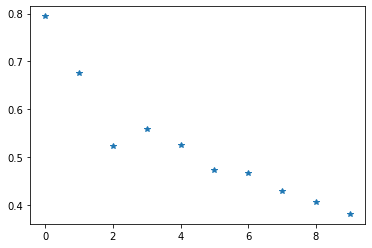

In [44]:
plt.plot(amplitudes, '*')

# Hamiltonian simulation

We are given three things

1. Block embedding of a Hamiltonian $H$, i.e. $U$ s.t. $H=\left(\langle 0|\otimes I \right)U\left(|0\rangle\otimes I\right)$.
2. Projectors $\Pi(\phi)$.
3. ??


## Block encodings

Singular value $\sigma$ are positive square roots of eigenvalues $M^\dagger M\ge0$.

To block encode some matrix $M$ we need $||M||\le1$ where $||\cdot||$ is the operator norm or, equivalently, the largest singular value.

In [90]:
class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*max(self.num_rows, self.num_cols)
        
        self.diagonal_block = self.pad_matrix_to_square(M)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
        
        self.projector = np.kron(np.diag([1, 0]), np.eye(self.dim//2))
                    
    @staticmethod
    def pad_matrix_to_square(M):
        """Pads a matrix with zeros to make it square."""

        n_rows, n_cols = M.shape
        n_max = max(n_rows, n_cols)
        S = np.zeros((n_max, n_max), dtype=np.complex64)
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n), dtype=np.complex64)
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n), atol=1e-5), 'Ops, block encoding is not unitary.'
        return U

## Implementation

- Success probability depends on the details of block encoding. 
- We assume $0\le spec(H)\le 1$.
- In our case we build bloc-encoding of $\frac12 e^{-i H t}$ and the algorithm successed with $\frac14$ chance.
- $C(e^{i\phi}U)=C(U)\cdot S\otimes I$




Firts let's build the polynomials and angles sequences.

In [221]:
seed = 42
np.random.seed(seed)

num_qubits = 6
N = 2**num_qubits

V = scipy.stats.unitary_group.rvs(N, random_state=seed)
D = np.random.uniform(low=0, high=1, size=(N,))

H = V*D @ V.conj().T

block_encoding = BlockEncoding(H)
U = block_encoding.unitary
P = block_encoding.projector

In [222]:
costx = pyqsp.poly.PolyCosineTX()
sintx = pyqsp.poly.PolySineTX()

t = np.arange(1, 10)
epsilon = 0.01

norms = []
degrees = []
for ti in t:

    U_phi = []
    degree = 0
    
    for target_function in [costx, sintx]:
        coeffs = quiet(target_function.generate)(tau=ti, epsilon=epsilon)
        phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(coeffs, signal_operator='Wx')
        phis = angles_from_Wx_to_R(phis)
        degree += len(phis)-1

        U_phi.append(apply_QSVT(U, P, P, phis))
    
    degrees.append(degree)
    
    U_phi_cos, U_phi_sin = U_phi
    H_cos = U_phi_cos[:N, :N]+U_phi_cos[:N, :N].conj().T
    H_sin = U_phi_sin[:N, :N]+U_phi_sin[:N, :N].conj().T
    H_transformed = H_cos -1j*H_sin
    
    norm = np.linalg.norm(H_transformed-scipy.linalg.expm(-1j*H*ti))
    norms.append(norm)

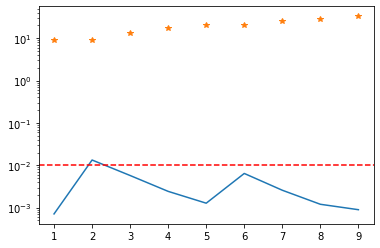

In [223]:
plt.plot(t, norms)
plt.axhline(epsilon, color='red', linestyle='--', label='error threshold')
plt.plot(t, degrees, '*')
plt.yscale('log')